In [1]:
#  Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

In [3]:
# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

pd.set_option('display.max_columns', None)

df = pd.read_csv('final_data.csv')

print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,id,last_scraped,price,accommodates,bathrooms_numeric,beds,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,neighbourhood_encoded
0,21853,2024-03-22,31.0,1,1.0,1.0,0.0,0.0,1.0,0.0,81.683544
1,24805,2024-03-22,92.0,3,1.0,2.0,1.0,0.0,0.0,0.0,137.034399
2,204570,2024-03-22,180.0,5,2.0,2.0,1.0,0.0,0.0,0.0,156.364564
3,205199,2024-03-22,65.0,2,1.0,1.0,1.0,0.0,0.0,0.0,137.034399
4,209373,2024-03-22,32.0,1,1.0,1.0,0.0,0.0,1.0,0.0,123.662213


In [6]:
# Convert date column to datetime
df['last_scraped'] = pd.to_datetime(df['last_scraped'])

# Make sure all numeric columns are properly typed
numeric_cols = ['price', 'accommodates', 'bathrooms_numeric', 'beds',
                'room_type_Entire home/apt', 'room_type_Hotel room',
                'room_type_Private room', 'room_type_Shared room',
                'neighbourhood_encoded']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

print("\nAfter conversion - Dataset info:")
df.info()


After conversion - Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101008 entries, 0 to 101007
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   id                         101008 non-null  int64         
 1   last_scraped               101008 non-null  datetime64[ns]
 2   price                      101008 non-null  float64       
 3   accommodates               101008 non-null  int64         
 4   bathrooms_numeric          101008 non-null  float64       
 5   beds                       100813 non-null  float64       
 6   room_type_Entire home/apt  101008 non-null  float64       
 7   room_type_Hotel room       101008 non-null  float64       
 8   room_type_Private room     101008 non-null  float64       
 9   room_type_Shared room      101008 non-null  float64       
 10  neighbourhood_encoded      101008 non-null  float64       
dtypes: datetime64[ns](

In [7]:
!pip install xgboost
!pip install optuna
#  Setup for Advanced Regression Models
import xgboost as xgb
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 19.3 MB/s eta 0:00:00


In [8]:
# Set random seed for reproducibility
np.random.seed(42)

# Feature Engineering
# Create engineered features to improve model performance

def engineer_features(df):
    """Create engineered features for improved model performance"""
    df_fe = df.copy()

    # Interaction terms
    df_fe['accommodates_beds'] = df_fe['accommodates'] * df_fe['beds']
    df_fe['accommodates_bathrooms'] = df_fe['accommodates'] * df_fe['bathrooms_numeric']
    df_fe['beds_bathrooms'] = df_fe['beds'] * df_fe['bathrooms_numeric']

    # Polynomial features
    df_fe['accommodates_squared'] = df_fe['accommodates'] ** 2
    df_fe['bathrooms_squared'] = df_fe['bathrooms_numeric'] ** 2
    df_fe['beds_squared'] = df_fe['beds'] ** 2

    # Ratio features
    df_fe['beds_per_person'] = df_fe['beds'] / df_fe['accommodates']
    df_fe['baths_per_person'] = df_fe['bathrooms_numeric'] / df_fe['accommodates']

    # Replace infinities with 0 (in case of division by zero)
    df_fe.replace([np.inf, -np.inf], 0, inplace=True)

    # Fill NaN values with 0
    df_fe.fillna(0, inplace=True)

    return df_fe

# Apply feature engineering to our dataset
df_fe = engineer_features(df)

In [9]:
df_fe.head()

,id,last_scraped,price,accommodates,bathrooms_numeric,beds,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,neighbourhood_encoded,accommodates_beds,accommodates_bathrooms,beds_bathrooms,accommodates_squared,bathrooms_squared,beds_squared,beds_per_person,baths_per_person
0,21853,2024-03-22,31.0,1,1.0,1.0,0.0,0.0,1.0,0.0,81.683544,1.0,1.0,1.0,1,1.0,1.0,1.000000,1.000000
1,24805,2024-03-22,92.0,3,1.0,2.0,1.0,0.0,0.0,0.0,137.034399,6.0,3.0,2.0,9,1.0,4.0,0.666667,0.333333
2,204570,2024-03-22,180.0,5,2.0,2.0,1.0,0.0,0.0,0.0,156.364564,10.0,10.0,4.0,25,4.0,4.0,0.400000,0.400000
3,205199,2024-03-22,65.0,2,1.0,1.0,1.0,0.0,0.0,0.0,137.034399,2.0,2.0,1.0,4,1.0,1.0,0.500000,0.500000
4,209373,2024-03-22,32.0,1,1.0,1.0,0.0,0.0,1.0,0.0,123.662213,1.0,1.0,1.0,1,1.0,1.0,1.000000,1.000000


In [10]:
# Prepare data for modeling
X_fe = df_fe.drop(['id', 'last_scraped', 'price'], axis=1)
y_fe = df_fe['price']

# Train-test split with the enhanced feature set
X_train, X_test, y_train, y_test = train_test_split(X_fe, y_fe, test_size=0.2, random_state=42)

# Standardize the features for better optimization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Number of features after engineering: {X_train.shape[1]}")
print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Number of features after engineering: 16
Train set shape: (80806, 16)
Test set shape: (20202, 16)


# XGBoost

In [ ]:
# Optuna Hyperparameter Optimization for XGBoost
def objective(trial):
    """Optuna objective function for XGBoost hyperparameter optimization"""
    # Hyperparameter search space
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
    }

    # Add parameters based on booster type
    if param['booster'] == 'gbtree' or param['booster'] == 'dart':
        param['max_depth'] = trial.suggest_int('max_depth', 3, 12)
        param['eta'] = trial.suggest_float('eta', 0.01, 0.3, log=True)
        param['gamma'] = trial.suggest_float('gamma', 1e-8, 1.0, log=True)
        param['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
        param['subsample'] = trial.suggest_float('subsample', 0.5, 1.0)
        param['colsample_bytree'] = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        param['min_child_weight'] = trial.suggest_int('min_child_weight', 1, 10)

    # K-fold cross-validation for more robust evaluation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, valid_idx in kf.split(X_train_scaled):
        X_train_fold, X_valid_fold = X_train_scaled[train_idx], X_train_scaled[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
        dvalid = xgb.DMatrix(X_valid_fold, label=y_valid_fold)

        # Train the model
        model = xgb.train(param, dtrain, num_boost_round=1000,
                          evals=[(dvalid, 'validation')],
                          early_stopping_rounds=50,
                          verbose_eval=False)

        # Predict and evaluate
        preds = model.predict(dvalid)
        rmse = np.sqrt(mean_squared_error(y_valid_fold, preds))
        cv_scores.append(rmse)

    # Return the mean RMSE across all folds
    return np.mean(cv_scores)

# Setup and run the optimization study
print("Starting Optuna hyperparameter optimization for XGBoost...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)  # Use more trials for better results

print("\nBest trial:")
trial = study.best_trial
print(f"  Value (RMSE): {trial.value:.4f}")
print("  Best hyperparameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")



[I 2025-04-23 09:51:00,284] A new study created in memory with name: no-name-5af09e03-c377-464e-8652-20798214672a


Starting Optuna hyperparameter optimization for XGBoost...


In [11]:
#  Train the optimized XGBoost model
# Get the best parameters from the study


best_params =  {
    'booster': 'gbtree',
    'lambda': 0.9104814210454353,
    'alpha': 1.213886019978349e-05,
    'max_depth': 6,
    'eta': 0.07708970936388457,
    'gamma': 0.0004693060323028388,
    'grow_policy': 'lossguide',
    'subsample': 0.8912801035803928,
    'colsample_bytree': 0.6544912688955683,
    'min_child_weight': 10,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

# Create a validation set from the training data
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_scaled, y_train, test_size=0.25, random_state=42)

# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train_final, label=y_train_final)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# Train the final model with the best parameters
print("\nTraining final XGBoost model with optimized hyperparameters...")
final_model = xgb.train(
    best_params,
    dtrain,
    num_boost_round=3000,
    evals=[(dtrain, 'train'), (dval, 'validation')],
    early_stopping_rounds=50,
    verbose_eval=100
)




Training final XGBoost model with optimized hyperparameters...
[0]	train-rmse:101.33095	validation-rmse:101.06901
[100]	train-rmse:76.91963	validation-rmse:77.48023
[200]	train-rmse:76.01929	validation-rmse:76.94158
[300]	train-rmse:75.32709	validation-rmse:76.57502
[400]	train-rmse:74.85740	validation-rmse:76.35157
[500]	train-rmse:74.48853	validation-rmse:76.18313
[600]	train-rmse:74.16454	validation-rmse:76.10232
[700]	train-rmse:73.89070	validation-rmse:76.01459
[800]	train-rmse:73.72982	validation-rmse:75.94680
[900]	train-rmse:73.51355	validation-rmse:75.86962
[1000]	train-rmse:73.34737	validation-rmse:75.80217
[1087]	train-rmse:73.20495	validation-rmse:75.76287


In [12]:
# Make predictions on the test set (only after training is complete)
y_pred_xgb = final_model.predict(dtest)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae = mean_absolute_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred_xgb)

print("\nXGBoost Model Evaluation:")
print(f"RMSE: ${rmse:.2f}")
print(f"MAE: ${mae:.2f}")
print(f"R²: {r2:.4f}")


XGBoost Model Evaluation:
RMSE: $76.24
MAE: $40.30
R²: 0.4649


In [14]:
#  Train additional models for comparison
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet

print("\n=== TRAINING OTHER MODELS ===")

# Function to evaluate and compare different models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print results
    print(f"\n{model_name} Model Performance:")
    print(f"RMSE: ${rmse:.2f}")
    print(f"MAE: ${mae:.2f}")
    print(f"R²: {r2:.4f}")

    return rmse, mae, r2, y_pred

# Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_metrics = evaluate_model(rf_model, X_train_scaled, X_test_scaled, y_train, y_test, "Random Forest")

# Ridge Regression
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_metrics = evaluate_model(ridge_model, X_train_scaled, X_test_scaled, y_train, y_test, "Ridge")

# Lasso Regression
lasso_model = Lasso(alpha=0.1, random_state=42)
lasso_metrics = evaluate_model(lasso_model, X_train_scaled, X_test_scaled, y_train, y_test, "Lasso")

# ElasticNet
elastic_model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_metrics = evaluate_model(elastic_model, X_train_scaled, X_test_scaled, y_train, y_test, "ElasticNet")




=== TRAINING OTHER MODELS ===

Random Forest Model Performance:
RMSE: $76.05
MAE: $40.47
R²: 0.4677

Ridge Model Performance:
RMSE: $83.23
MAE: $44.47
R²: 0.3624

Lasso Model Performance:
RMSE: $83.13
MAE: $44.43
R²: 0.3638

ElasticNet Model Performance:
RMSE: $83.15
MAE: $44.31
R²: 0.3635



Model Comparison:
           Model       RMSE        R²
1  Random Forest  76.045249  0.467676
0        XGBoost  76.242092  0.464916
3          Lasso  83.134896  0.363792
4     ElasticNet  83.152085  0.363529
2          Ridge  83.227148  0.362380


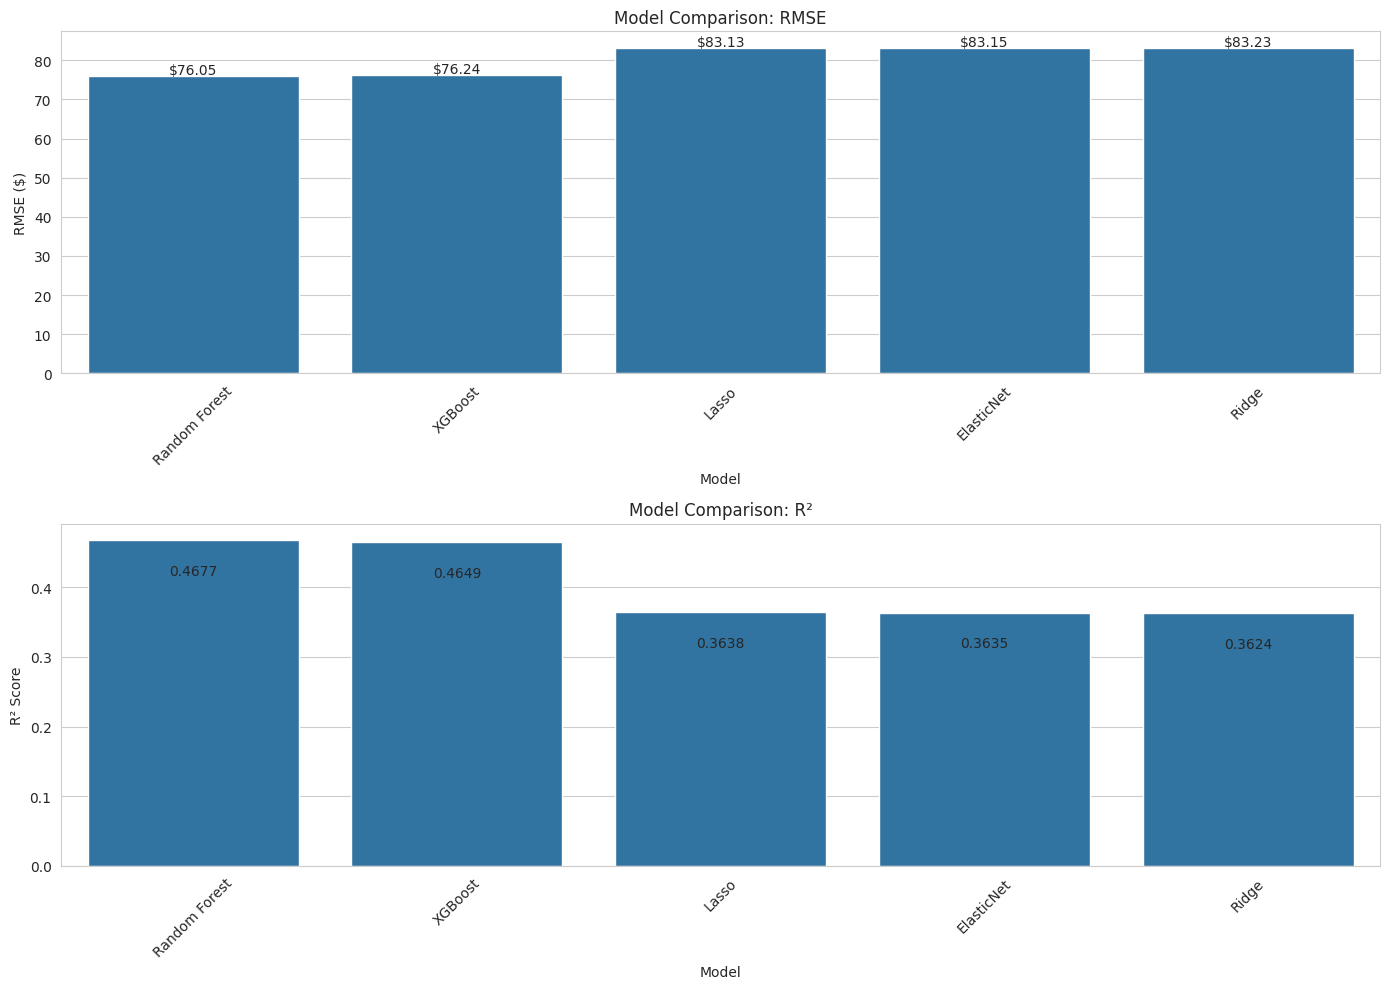

In [17]:
# Compare model performances
model_names = ['XGBoost', 'Random Forest', 'Ridge', 'Lasso', 'ElasticNet']
rmse_values = [rmse, rf_metrics[0], ridge_metrics[0], lasso_metrics[0], elastic_metrics[0]]
r2_values = [r2, rf_metrics[2], ridge_metrics[2], lasso_metrics[2], elastic_metrics[2]]

# Create a comparison dataframe
comparison_df = pd.DataFrame({
    'Model': model_names,
    'RMSE': rmse_values,
    'R²': r2_values
})

# Sort by RMSE (lower is better)
comparison_df = comparison_df.sort_values('RMSE')

print("\nModel Comparison:")
print(comparison_df)

# Visualize model comparison
plt.figure(figsize=(14, 10))

# RMSE comparison
plt.subplot(2, 1, 1)
sns.barplot(x='Model', y='RMSE', data=comparison_df)
plt.title('Model Comparison: RMSE')
plt.ylabel('RMSE ($)')
plt.xticks(rotation=45)

for i, v in enumerate(comparison_df['RMSE']):
    plt.text(i, v + 0.5, f'${v:.2f}', ha='center')

# R² comparison
plt.subplot(2, 1, 2)
sns.barplot(x='Model', y='R²', data=comparison_df)
plt.title('Model Comparison: R²')
plt.ylabel('R² Score')
plt.xticks(rotation=45)

for i, v in enumerate(comparison_df['R²']):
    plt.text(i, v - 0.05, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()


# Random Forest Model

In [20]:
from sklearn.ensemble import RandomForestRegressor

In [21]:
# Create proper train-test split
# We'll keep the test set completely separate from the optimization process
X_train_full, X_test, y_train_full, y_test = train_test_split(X_fe, y_fe, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

print(f"Number of features after engineering: {X_train_full.shape[1]}")
print(f"Training set shape: {X_train_full.shape}")
print(f"Test set shape: {X_test.shape}")


Number of features after engineering: 16
Training set shape: (80806, 16)
Test set shape: (20202, 16)


In [23]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score

def objective(trial):
    """Optuna objective function for Random Forest hyperparameter optimization"""
    # Define the hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 25),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }

    if params['bootstrap']:
        params['oob_score'] = trial.suggest_categorical('oob_score', [True, False])
    else:
        params['oob_score'] = False

    # Use K-fold cross-validation to get a robust estimate of performance
    # This way we never expose the test set during optimization
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize the Random Forest model
    model = RandomForestRegressor(
        **params,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )

    # Perform cross-validation and return the mean RMSE
    cv_scores = -cross_val_score(model, X_train_full_scaled, y_train_full,
                                cv=cv, scoring='neg_root_mean_squared_error')

    return np.mean(cv_scores)  # Return mean RMSE (lower is better)

# Cell 5: Run Optuna Study for Random Forest
print("Starting Optuna hyperparameter optimization for Random Forest...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

[I 2025-04-29 10:12:04,551] A new study created in memory with name: no-name-0d8addd5-5dbd-4cdd-b353-5c0955797861


Starting Optuna hyperparameter optimization for Random Forest...


[I 2025-04-29 10:14:21,153] Trial 0 finished with value: 78.0461031239257 and parameters: {'n_estimators': 202, 'max_depth': 14, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 78.0461031239257.
[I 2025-04-29 10:15:12,866] Trial 1 finished with value: 73.40711608475652 and parameters: {'n_estimators': 219, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True, 'oob_score': False}. Best is trial 1 with value: 73.40711608475652.
[I 2025-04-29 10:16:37,080] Trial 2 finished with value: 80.48279616890366 and parameters: {'n_estimators': 184, 'max_depth': 7, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': False}. Best is trial 1 with value: 73.40711608475652.
[I 2025-04-29 10:17:46,664] Trial 3 finished with value: 77.29760251533095 and parameters: {'n_estimators': 432, 'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 4, '

In [25]:
# {'n_estimators': 104, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True, 'oob_score': False}

In [24]:
# Get the best parameters from the study
#best_params = study.best_params
best_params = {'n_estimators': 104, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True, 'oob_score': False}

# Initialize the model with the best parameters
rf_best = RandomForestRegressor(
    **best_params,
    random_state=42,
    n_jobs=-1
)

# Fit the model on the full training set
print("\nTraining final Random Forest model with optimized hyperparameters...")
rf_best.fit(X_train_full_scaled, y_train_full)


Training final Random Forest model with optimized hyperparameters...


RandomForestRegressor(max_depth=24, max_features=None, n_estimators=104,
                      n_jobs=-1, random_state=42)

In [26]:
# Make predictions on the test set
y_pred_rf = rf_best.predict(X_test_scaled)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae = mean_absolute_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Model Evaluation:")
print(f"RMSE: ${rmse:.2f}")
print(f"MAE: ${mae:.2f}")
print(f"R²: {r2:.4f}")



Random Forest Model Evaluation:
RMSE: $72.92
MAE: $37.93
R²: 0.5105


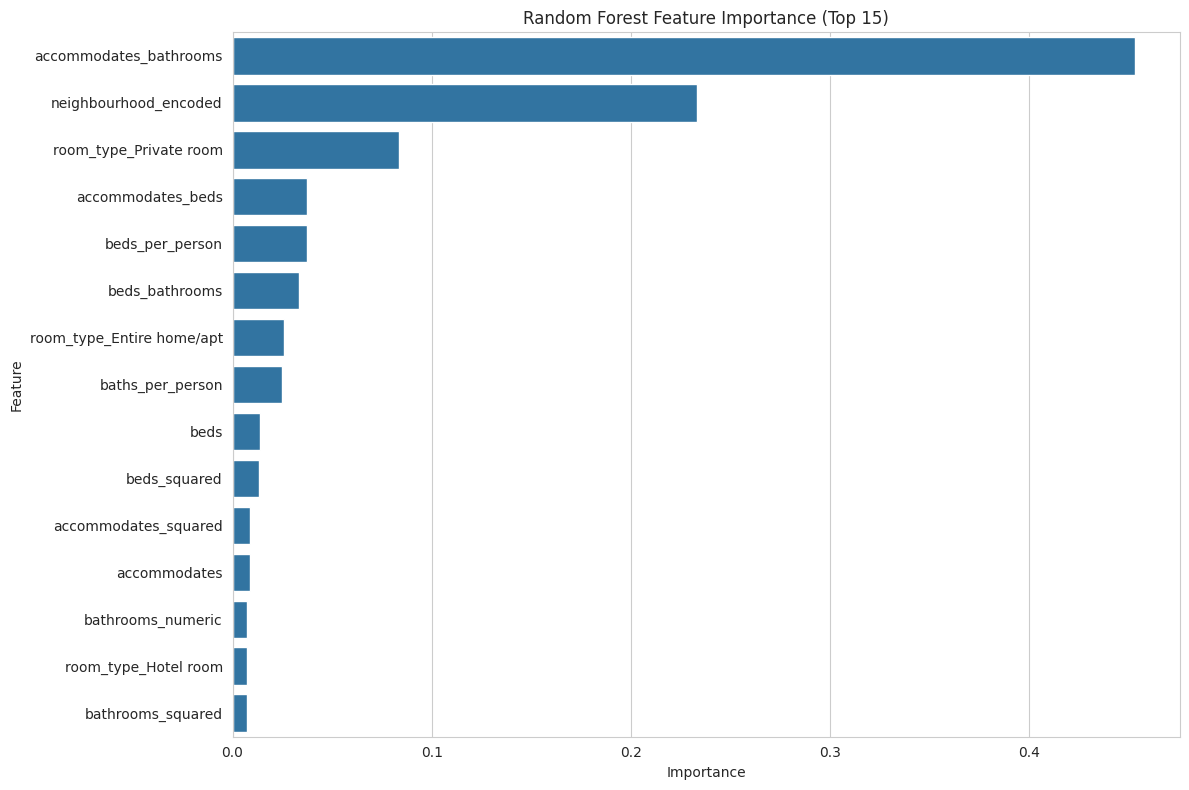

In [27]:
# Get feature importance
feature_importance = rf_best.feature_importances_
feature_names = X_train_full.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Calculate percentage of total importance
total_importance = importance_df['Importance'].sum()
importance_df['Importance_Percentage'] = (importance_df['Importance'] / total_importance) * 100

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Random Forest Feature Importance (Top 15)')
plt.tight_layout()
plt.show()


In [28]:
# Check for OVERFITTING in the Random Forest model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Compute predictions for both training and test sets
y_pred_train = rf_best.predict(X_train_full_scaled)
y_pred_test = rf_best.predict(X_test_scaled)

# Calculate metrics for both sets
train_rmse = np.sqrt(mean_squared_error(y_train_full, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train_full, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

# Print performance comparison
print("Random Forest Performance Comparison:")
print(f"Training RMSE: ${train_rmse:.2f}")
print(f"Test RMSE: ${test_rmse:.2f}")
print(f"RMSE difference: ${test_rmse - train_rmse:.2f}")
print(f"RMSE ratio (test/train): {test_rmse / train_rmse:.2f}x")
print("\n")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"R² difference: {test_r2 - train_r2:.4f}")

# Calculate overfitting percentage
overfitting_percentage = ((test_rmse - train_rmse) / train_rmse) * 100
print(f"\nOverfitting percentage: {overfitting_percentage:.2f}%")


Random Forest Performance Comparison:
Training RMSE: $67.24
Test RMSE: $72.92
RMSE difference: $5.69
RMSE ratio (test/train): 1.08x


Training R²: 0.5853
Test R²: 0.5105
R² difference: -0.0748

Overfitting percentage: 8.46%


Text(0.5, 1.0, 'Random Forest: Residuals Plot')

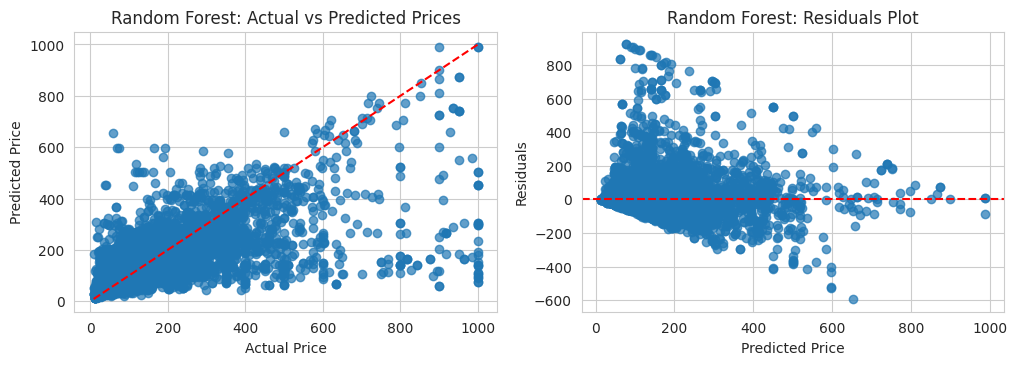

In [29]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 8))

# Actual vs Predicted
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Random Forest: Actual vs Predicted Prices')

# Residual plot
residuals = y_test - y_pred_rf
plt.subplot(2, 2, 2)
plt.scatter(y_pred_rf, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Random Forest: Residuals Plot')

In [30]:
# Cell 9: Price Prediction Function
def predict_price_rf(accommodates, bathrooms, beds, room_type, neighbourhood_val):
    """
    Predict the price for a given accommodation using the optimized Random Forest model.

    Parameters:
    - accommodates: Number of people it accommodates
    - bathrooms: Number of bathrooms
    - beds: Number of beds
    - room_type: 'Entire home/apt', 'Hotel room', 'Private room', or 'Shared room'
    - neighbourhood_val: Neighbourhood encoded value

    Returns:
    - Predicted price
    """
    # Create a DataFrame with the input values
    input_data = pd.DataFrame({
        'accommodates': [accommodates],
        'bathrooms_numeric': [bathrooms],
        'beds': [beds],
        'room_type_Entire home/apt': [1 if room_type == 'Entire home/apt' else 0],
        'room_type_Hotel room': [1 if room_type == 'Hotel room' else 0],
        'room_type_Private room': [1 if room_type == 'Private room' else 0],
        'room_type_Shared room': [1 if room_type == 'Shared room' else 0],
        'neighbourhood_encoded': [neighbourhood_val]
    })

    # Apply feature engineering
    input_engineered = engineer_features(input_data)

    # Drop id and last_scraped columns if they exist
    if 'id' in input_engineered.columns:
        input_engineered = input_engineered.drop('id', axis=1)
    if 'last_scraped' in input_engineered.columns:
        input_engineered = input_engineered.drop('last_scraped', axis=1)
    if 'price' in input_engineered.columns:
        input_engineered = input_engineered.drop('price', axis=1)

    # Scale the features
    input_scaled = scaler.transform(input_engineered)

    # Make prediction
    predicted_price = rf_best.predict(input_scaled)[0]

    return max(0, round(predicted_price, 2))  # Ensure non-negative price

In [31]:
example_price = predict_price_rf(
    accommodates=4,
    bathrooms=2,
    beds=3,
    room_type='Entire home/apt',
    neighbourhood_val=130.0
)

print(f"\nExample prediction using Random Forest model:")
print(f"For a 4-person, 2-bathroom, 3-bed entire home in neighbourhood value 130:")
print(f"Predicted price: ${example_price:.2f}")



Example prediction using Random Forest model:
For a 4-person, 2-bathroom, 3-bed entire home in neighbourhood value 130:
Predicted price: $233.36


In [32]:
import joblib
import os

# Create models directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Save the Random Forest model
joblib.dump(rf_best, 'models/rf_pipeline_model_finall.joblib')
print("Random Forest model saved to: models/random_forest_model.joblib")

# Save the scaler
joblib.dump(scaler, 'models/scaler.joblib')
print("Scaler saved to: models/scaler.joblib")

Random Forest model saved to: models/random_forest_model.joblib
Scaler saved to: models/scaler.joblib


In [37]:
# Load the model and scaler
loaded_model = joblib.load('models/rf_pipeline_model_finall.joblib')
loaded_scaler = joblib.load('models/scaler.joblib')

print("\nModel and scaler loaded successfully")

# Make a test prediction with the loaded model
import pandas as pd
import numpy as np

def predict_price(model, scaler, accommodates, bathrooms, beds, room_type, neighbourhood_val):
    """Simple function to make a price prediction"""
    # Create input data
    input_data = pd.DataFrame({
        'accommodates': [accommodates],
        'bathrooms_numeric': [bathrooms],
        'beds': [beds],
        'room_type_Entire home/apt': [1 if room_type == 'Entire home/apt' else 0],
        'room_type_Hotel room': [1 if room_type == 'Hotel room' else 0],
        'room_type_Private room': [1 if room_type == 'Private room' else 0],
        'room_type_Shared room': [1 if room_type == 'Shared room' else 0],
        'neighbourhood_encoded': [neighbourhood_val]
    })

    # Apply feature engineering (simplified version with just the necessary features)
    input_fe = input_data.copy()
    input_fe['accommodates_beds'] = input_fe['accommodates'] * input_fe['beds']
    input_fe['accommodates_bathrooms'] = input_fe['accommodates'] * input_fe['bathrooms_numeric']
    input_fe['beds_bathrooms'] = input_fe['beds'] * input_fe['bathrooms_numeric']
    input_fe['accommodates_squared'] = input_fe['accommodates'] ** 2
    input_fe['bathrooms_squared'] = input_fe['bathrooms_numeric'] ** 2
    input_fe['beds_squared'] = input_fe['beds'] ** 2
    input_fe['beds_per_person'] = input_fe['beds'] / input_fe['accommodates']
    input_fe['baths_per_person'] = input_fe['bathrooms_numeric'] / input_fe['accommodates']
    input_fe.replace([np.inf, -np.inf], 0, inplace=True)
    input_fe.fillna(0, inplace=True)

    # Scale features
    input_scaled = scaler.transform(input_fe)

    # Make prediction
    prediction = model.predict(input_scaled)[0]

    return round(prediction, 2)

# Test prediction
price = predict_price(
    model=loaded_model,
    scaler=loaded_scaler,
    accommodates=4,
    bathrooms=2,
    beds=3,
    room_type='Entire home/apt',
    neighbourhood_val=130.0
)

print(f"Test prediction for a 4-person, 2-bathroom, 3-bed entire home: ${price}")


Model and scaler loaded successfully
Test prediction for a 4-person, 2-bathroom, 3-bed entire home: $233.36
